In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from math import sqrt
%matplotlib inline
sns.set(style="darkgrid")
import warnings
warnings.filterwarnings('ignore')

### 1. Классификация. Симптомы болей в спине и классификация тяжести возможной болезни.

In [2]:
data = pd.read_csv("Dataset_spine.csv")

In [3]:
data.shape

(310, 14)

### 2. Препроцессинг данных

In [4]:
data.columns

Index(['Col1', 'Col2', 'Col3', 'Col4', 'Col5', 'Col6', 'Col7', 'Col8', 'Col9',
       'Col10', 'Col11', 'Col12', 'Class_att', 'Unnamed: 13'],
      dtype='object')

In [5]:
del data['Unnamed: 13']
data['Class_att'] = data['Class_att'].map({'Abnormal':1, 'Normal':0})
data.head()

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12,Class_att
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,0.744503,12.5661,14.5386,15.30468,-28.658501,43.5123,1
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,0.415186,12.8874,17.5323,16.78486,-25.530607,16.1102,1
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,0.474889,26.8343,17.4861,16.65897,-29.031888,19.2221,1
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,0.369345,23.5603,12.7074,11.42447,-30.470246,18.8329,1
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,0.543360,35.4940,15.9546,8.87237,-16.378376,24.9171,1


### 2*. Посмотрим на корреляцию данных. Можно заметить возмущения в первых столбцах, некоторые симптомы ведут за собой другие.

<AxesSubplot:>

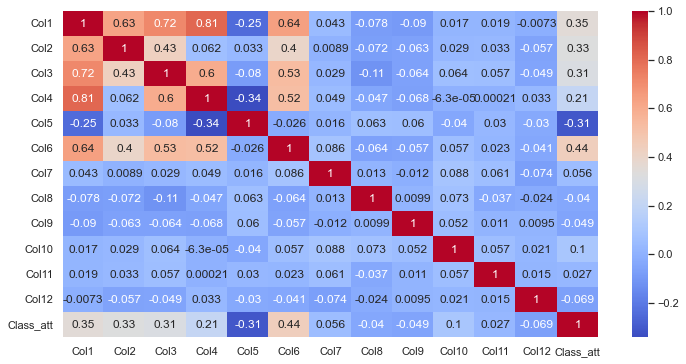

In [6]:
figure = plt.figure(figsize=(12,6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')

### Реализация метрики качества.

Так как у нас всего два класса, используем оценки качества precision и recall, но нам надо обьеденить их в одну, поэтому используем новое выражение называемое F-мерой, который считается как 
```(1 + betta**2) * (precision * recall) / ((betta**2 * precision) + recall)```

In [7]:
def F(x, y, betta=1):
    assert len(x) == len(y)
    TP = sum([x[i] == 1 and y[i] == 1 for i in range(len(x))])
    FP = sum([x[i] == 1 and y[i] == 0 for i in range(len(x))])
    FN = sum([x[i] == 0 and y[i] == 1 for i in range(len(x))])
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    return (1 + betta**2) * (precision * recall) / ((betta**2 * precision) + recall)

### Реализация Standart Scaller

In [8]:
def scaller(data):
    data = data.transpose()
    for row in data:
        avg = sum([x for x in row]) / len(row)
        dist = sqrt(sum([(x-avg)**2 for x in row]) / len(row))
        for i in range(len(row)):
            row[i] = (row[i] - avg) / dist
    return data.transpose()

### Разбиение на обучающую и тестовую выборки

In [9]:
indicators = ['Col1', 'Col2', 'Col3', 'Col4', 'Col5', 'Col6', 'Col7', 'Col8', 'Col9',
       'Col10', 'Col11', 'Col12']
target_columns = ['Class_att']

In [10]:
X = data[indicators]
y = data[target_columns]

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y, test_size=0.2, random_state=10)

In [12]:
X_scalled = scaller(X.to_numpy())

In [13]:
X_train_S, X_test_S, y_train_S, y_test_S = train_test_split(X_scalled, y, test_size=0.2, random_state=10)

In [14]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((248, 12), (62, 12), (248, 1), (62, 1))

### Реализация и обучение логистической регрессии

In [15]:
class LR:
    def __init__(self, step=10**-2, it_c=1400, batch=3000):
        self.step = step
        self.it_c = it_c
        self.batch = batch

    def get_coeff(self, x, y):
        return self.err(x, y.values.ravel())
    
    def err(self, x, y):
        p = [self.predict(i) for i in x]
        return sum(p==y) / len(y)
    
    def reg(self):
        return 0
    
    def fit(self, x, y, X_valid=X_test, y_valid=y_test):
        y_valid = y_valid.values.ravel()
        y = y.values.ravel()
        np.c_[x, np.ones(len(x))]
        self.w = np.zeros(x.shape[1])
        f,h = [],[]
        for i in range(self.it_c):
            z = [sum([x[i][j]*self.w[j] for j in range(len(x[i]))]) for i in range(len(x))]
            res = np.array([1 / (1 + np.exp(-a)) for a in z])
            grad = np.dot(x.T, res - y) / y.size
            self.w -= self.step * grad - self.reg()
            error = self.err(x, y)
            h.append(error)
            F_norm = F(self.predict(X_valid), y_valid)
            f.append(F_norm)
        return h, f
    
    def fit_batch(self, x, y):
        hist = []
        for b in range(0, len(x), self.batch):
            xx = x[b:min(b+self.batch,len(x))]
            yy = y[b:min(b+self.batch,len(x))]
            hist += self.fit(xx, yy)
        return hist
            
    def predict(self, x):
        np.append(x,1)
        return (1 / (1 + np.exp(-np.dot(x, self.w)))).round()
    
    def F_mera(self, x, y):
        f(x,y)

### Добавление регуляризации

In [16]:
class LRreg(LR):
    def __init__(self, step=10**-2, it_c=1400, batch=6000, L=None, alpha=0.0001):
        self.step = step
        self.it_c = it_c
        self.batch = batch
        self.L = L
        self.alpha = alpha
        
    def reg(self):
        if self.L == 'L1':
            return self.alpha * sum([abs(i) for i in self.w])
        elif self.L == 'L2':
            return self.alpha * sum([i**2 for i in self.w])
        else:
            return 0

### Оценка качества модели на обучающей и тестовой выборках

In [17]:
mlg = LR()
hist, f = mlg.fit(X_train, y_train)
print(f"my LogReg: {mlg.get_coeff(X_test, y_test)}")

my LogReg: 0.7096774193548387


In [18]:
mlgL1 = LRreg(L='L1')
histL1, fL1 = mlgL1.fit(X_train, y_train)
print(f"my LogReg L1: {mlgL1.get_coeff(X_test, y_test)}")

my LogReg L1: 0.8064516129032258


In [19]:
mlgL2 = LRreg(L='L2')
histL2, fL2 = mlgL2.fit(X_train, y_train)
print(f"my LogReg L2: {mlgL2.get_coeff(X_test, y_test)}")

my LogReg L2: 0.8387096774193549


### График точности моделей для всех регулязациях (без нее, L1, L2)

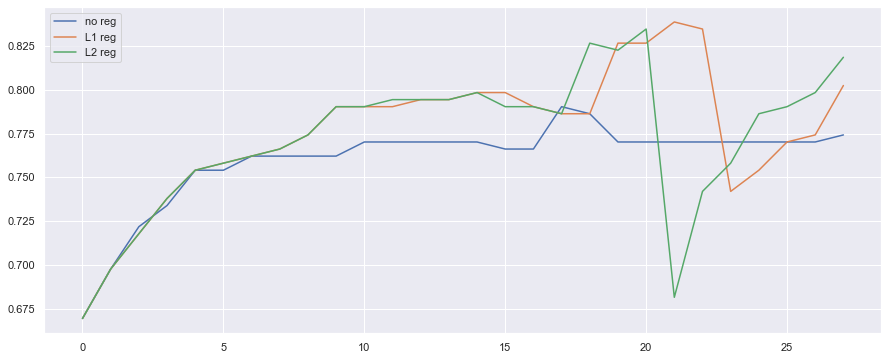

In [20]:
figure = plt.figure(figsize=(15,6))
plt.plot(hist[::50], label="no reg")
plt.plot(histL1[::50], label="L1 reg")
plt.plot(histL2[::50], label="L2 reg")
plt.legend()
plt.show()

### График метрики моделей для всех регулязациях (без нее, L1, L2) чем больше тем лучше

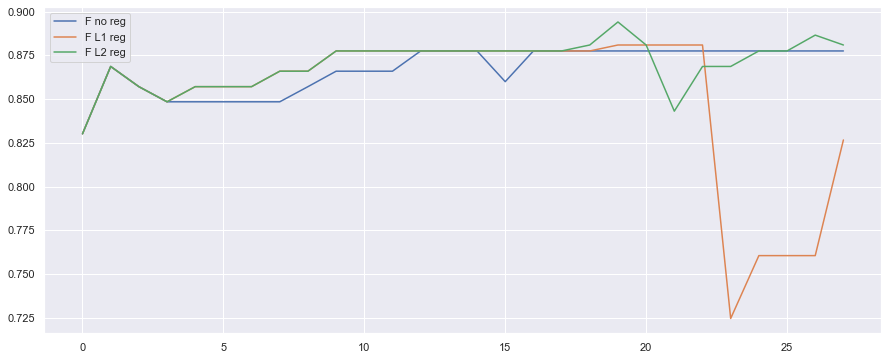

In [21]:
figure = plt.figure(figsize=(15,6))
plt.plot(f[::50], label="F no reg")
plt.plot(fL1[::50], label="F L1 reg")
plt.plot(fL2[::50], label="F L2 reg")
plt.legend()
plt.show()

### Оценка качества модели на обучающей и тестовой выборках которые прошли Scaller

In [22]:
mlg = LR()
hist, f = mlg.fit(X_train_S, y_train_S)
print(f"my LogReg: {mlg.get_coeff(X_test_S, y_test_S)}")

my LogReg: 0.6612903225806451


In [23]:
mlgL1 = LRreg(L='L1')
histL1, fL1 = mlgL1.fit(X_train_S, y_train_S)
print(f"my LogReg L1: {mlgL1.get_coeff(X_test_S, y_test_S)}")

my LogReg L1: 0.6290322580645161


In [24]:
mlgL2 = LRreg(L='L2')
histL2, fL2 = mlgL2.fit(X_train_S, y_train_S)
print(f"my LogReg L2: {mlgL2.get_coeff(X_test_S, y_test_S)}")

my LogReg L2: 0.6774193548387096


### Обучить логистическую регрессию или линейную регрессию из sklearn, оценить качество модели на обучающей и тестовой выборках и сравнить со своей моделью

In [25]:
from sklearn.linear_model import LogisticRegression
sklg = LogisticRegression(max_iter=3000)
sklg.fit(X_train, y_train.values.ravel())
print(f"sklearn: {sklg.score(X_test, y_test.values.ravel())}")

sklearn: 0.8709677419354839


In [26]:
from sklearn.linear_model import LogisticRegression
sklg = LogisticRegression(max_iter=3000)
sklg.fit(X_train_S, y_train_S.values.ravel())
print(f"sklearn: {sklg.score(X_test_S, y_test_S.values.ravel())}")

sklearn: 0.8548387096774194


### Сделать график ошибки модели из sklearn на обучающей и тестовой выборках и сравнить со своей моделью
### Сделать график точности модели из sklearn на обучающей и тестовой выборках и сравнить со своей моделью

In [27]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, valid_scores = learning_curve(
    LogisticRegression(max_iter=1400), X_train, y_train.values.ravel(), cv=5)

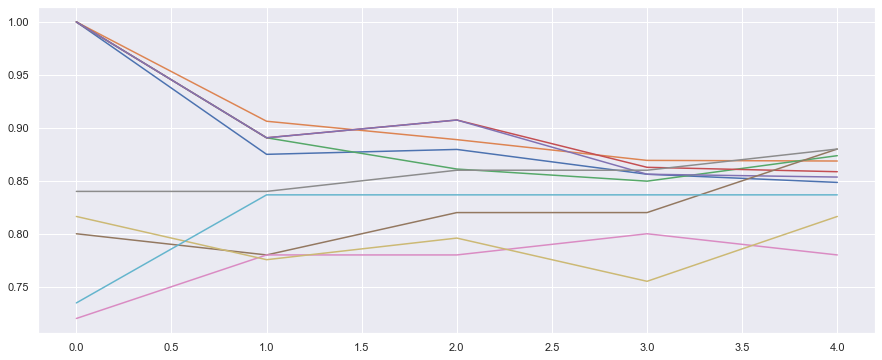

In [28]:
figure = plt.figure(figsize=(15,6))
plt.plot(train_scores)
plt.plot(valid_scores)
plt.show()

### Создадим функцию для поиска наилучших гиперпараметров

In [29]:
def GridSearch(step, it_c, L, alpha, Xy_train, Xy_test):
    bestF = 0
    best_estimators = {'step':None, 'it_c':None, 'L':None, 'alpha':None}
    best_model = None
    model,h,f = None, None, None
    for s in step:
        for it in it_c:
            for l in L:
                if l == 'L1':
                    for alp in alpha:
                        model = LRreg(step=s, it_c=it, L='L1', alpha=alp)
                        h,f = model.fit(Xy_train[0], Xy_train[1], Xy_test[0], Xy_test[1])
                        if f[-1] > bestF:
                            bestF=f[-1]
                            best_model=model
                            best_estimators={'step':s, 'it_c':it, 'L':l, 'alpha':alp}
                            print(bestF, best_estimators)
                elif l == 'L2':
                    for alp in alpha:
                        model = LRreg(step=s, it_c=it, L='L1', alpha=alp)
                        h,f = model.fit(Xy_train[0], Xy_train[1], Xy_test[0], Xy_test[1])
                        if f[-1] > bestF:
                            bestF=f[-1]
                            best_model=model
                            best_estimators={'step':s, 'it_c':it, 'L':l, 'alpha':alp}
                            print(bestF, best_estimators)
                else:
                    mlg = LR()
                    h,f = mlg.fit(X_train, y_train)
                    if f[-1] > bestF:
                        bestF=f[-1]
                        best_model=model
                        best_estimators={'step':s, 'it_c':it, 'L':None, 'alpha':None}
                        print(bestF, best_estimators)
                        
    return best_model, bestF, best_estimators

In [30]:
m, f, est = GridSearch([10**-2,10**-3,10**-1],
                       [600,1000,1200,1400],
                       ['','L1','L2'],
                       [0.0001,0.00001],
                       [X_train, y_train],
                       [X_test, y_test])

0.7428571428571429 {'step': 0.01, 'it_c': 300, 'L': None, 'alpha': None}
0.7605633802816901 {'step': 0.01, 'it_c': 300, 'L': 'L1', 'alpha': 0.0001}
0.7777777777777778 {'step': 0.01, 'it_c': 400, 'L': 'L1', 'alpha': 1e-05}
0.8809523809523809 {'step': 0.01, 'it_c': 1000, 'L': 'L1', 'alpha': 0.0001}


In [31]:
f, est

(0.8809523809523809, {'step': 0.01, 'it_c': 1000, 'L': 'L1', 'alpha': 0.0001})

### Обучим модель с данными параметрами

In [33]:
model = LRreg(L='L1', step=0.01, it_c=1000, alpha=0.0001)
h, f = model.fit(X_train, y_train)
print(f"my best LogReg L1: {model.get_coeff(X_test, y_test)}")

my best LogReg L1: 0.8387096774193549


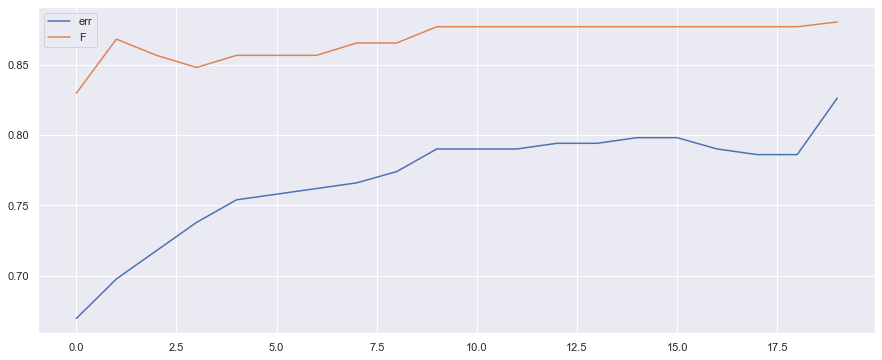

In [34]:
figure = plt.figure(figsize=(15,6))
plt.plot(h[::50], label="err")
plt.plot(f[::50], label="F")
plt.legend()
plt.show()